# Piomas

In [1]:
import requests
import pandas as pd
import io
import gzip
import re
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from pathlib import Path

graphs_path = Path('graphs')
output_path = Path('output')

graphs_path.mkdir(exist_ok=True)
output_path.mkdir(exist_ok=True)

C:\Users\gbalestrieri\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Functions

In [2]:
def dayofyear_todatetime(year, day_of_year):
    return pd.Timestamp(str(year)) + pd.Timedelta(days=day_of_year-1)

In [3]:
def pivot_months(my_series):
    df = pd.DataFrame(my_series)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    return df.pivot_table(values=my_series.name, index='Year', columns='Month')

## Query data

In [4]:
# %% GET FILE
r = requests.get('http://psc.apl.uw.edu/wordpress/wp-content/uploads/schweiger/ice_volume/PIOMAS.vol.daily.1979.2018.Current.v2.1.dat.gz')

assert r.ok, f"Query failed with status code {response.status_code}" + \
             f"\nFull message: {response.text}"

# %% PARSE TABLE
buf = io.BytesIO(r.content)
gzip_f = gzip.GzipFile(fileobj=buf)
content = gzip_f.read()
str_data = content.decode("utf-8")
str_data = re.sub(' +', ' ', str_data)
csv = io.StringIO(str_data)
df = pd.read_csv(csv, sep=' ')

df.head()

,Year,#day,Vol
0,1979,1,26.405
1,1979,2,26.496
2,1979,3,26.582
3,1979,4,26.672
4,1979,5,26.770


### Extract series

In [5]:
# %% EXTRACT SERIES
idx = df.apply(lambda row: dayofyear_todatetime(int(row['Year']), row['#day']), axis=1)
series = pd.Series(df['Vol'].values, index=idx, name='Vol')
series = series.resample('D').interpolate() # adding missing data (31-12 of leap years) through linear interpolation

series.head()

1979-01-01    26.405
1979-01-02    26.496
1979-01-03    26.582
1979-01-04    26.672
1979-01-05    26.770
Freq: D, Name: Vol, dtype: float64

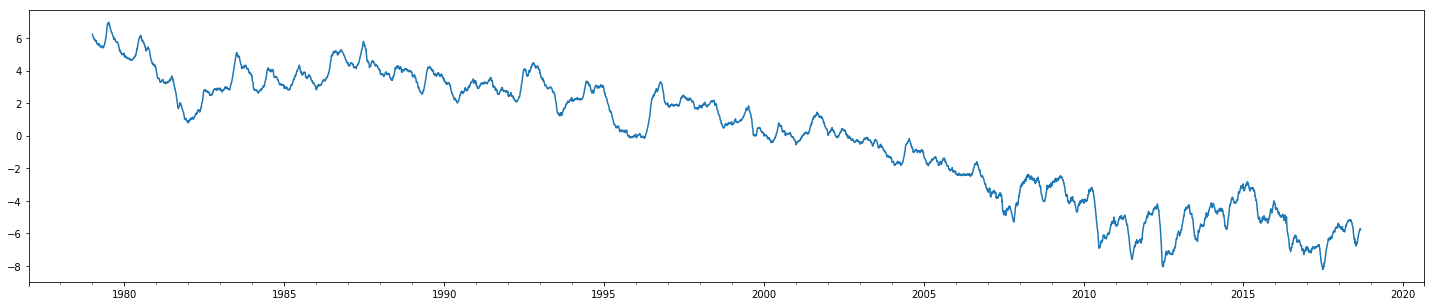

In [6]:
roll_mean = series.rolling(365).mean()
day_mean = df.groupby('#day')['Vol'].mean().reset_index()
seasonality = pd.merge(df[['Year', '#day']], day_mean, 'right').sort_values(['Year', '#day'])

seasonality = pd.Series(seasonality['Vol'].values, index=idx)
seasonality = seasonality.resample('D').interpolate()
trend = series - seasonality

trend.plot(figsize=(25,5));

## Fit and forecast

In [7]:
# from pandas.plotting import autocorrelation_plot
# pd.plotting.autocorrelation_plot(trend)

forecast = ARIMA(trend, order=(5,1,0))
forecast_fit = forecast.fit(disp=0)

forecast_fit.summary()

next_day = (trend.index[-1].dayofyear + 1) % 365
build_index = lambda x: list(range(x, 366)) + list(range(1, x))
next_year_index = build_index(next_day)

next_year = forecast_fit.forecast(365)

next_year_avg = pd.Series(next_year[0], index=next_year_index)
next_year_min = pd.Series(list(zip(*next_year[2]))[0], index=next_year_index)
next_year_max = pd.Series(list(zip(*next_year[2]))[1], index=next_year_index)

day_mean.set_index('#day', inplace=True)
day_mean = day_mean.squeeze()
sorted_day_mean = day_mean.reindex(next_year_index)

next_year_min += sorted_day_mean
next_year_avg += sorted_day_mean
next_year_max += sorted_day_mean

series_min = series.append(next_year_min, ignore_index=True)
series_centr = series.append(next_year_avg, ignore_index=True)
series_max = series.append(next_year_max, ignore_index=True)

final_index = pd.date_range(start=series.index[0], end=series.index[-1]+pd.Timedelta(days=365), freq='D')

series_min.index = final_index
series_centr.index = final_index
series_max.index = final_index

## Plots

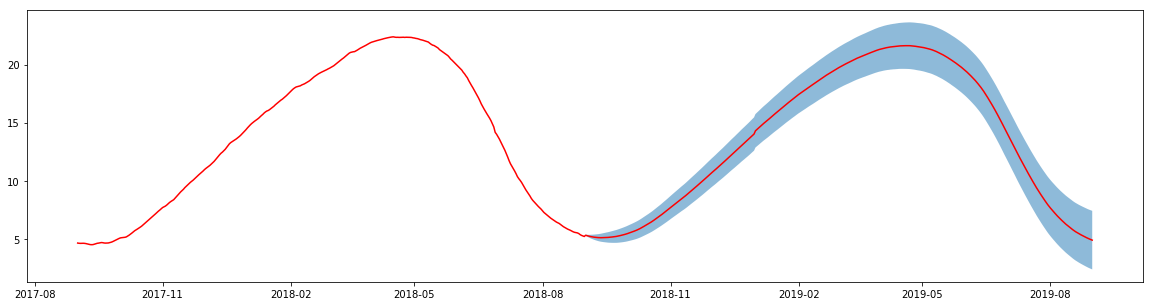

In [8]:
# %%
my_slice = slice(len(series_centr)-730, len(series_centr))
# my_slice = slice(0, len(series_centr))
plt.figure(figsize=(20, 5))
plt.plot(series_centr[my_slice], color='red')
plt.fill_between(series_min[my_slice].index, series_min[my_slice].values, series_max[my_slice].values, alpha=0.5);

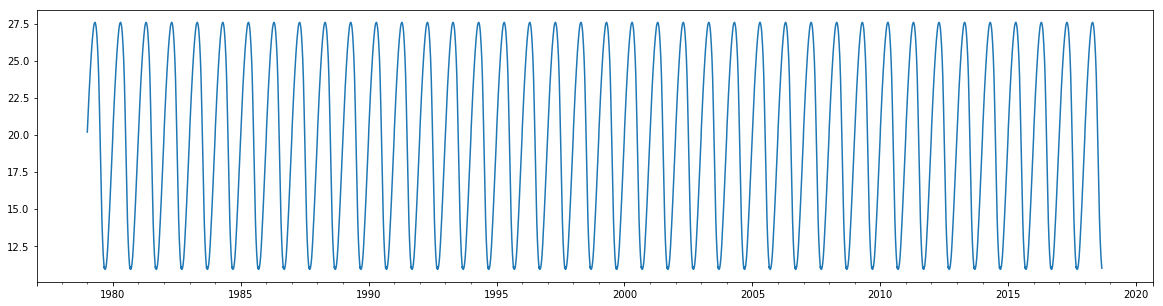

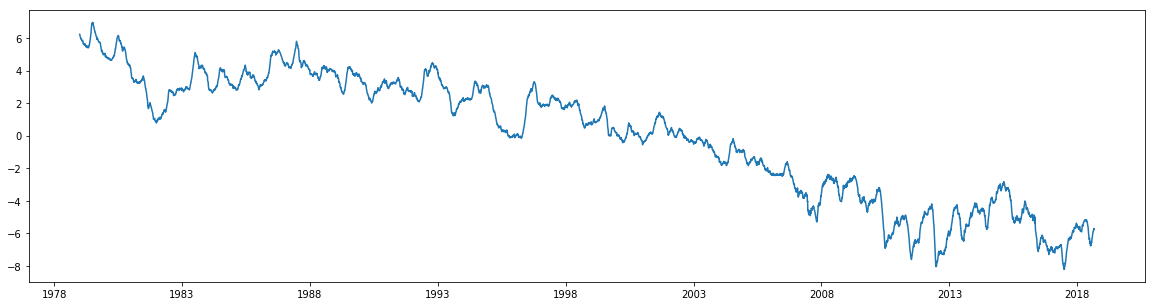

In [9]:
# %%
plt.figure(figsize=(20, 5))
seasonality.plot()

# %%
plt.figure(figsize=(20, 5))
plt.plot(series - seasonality);

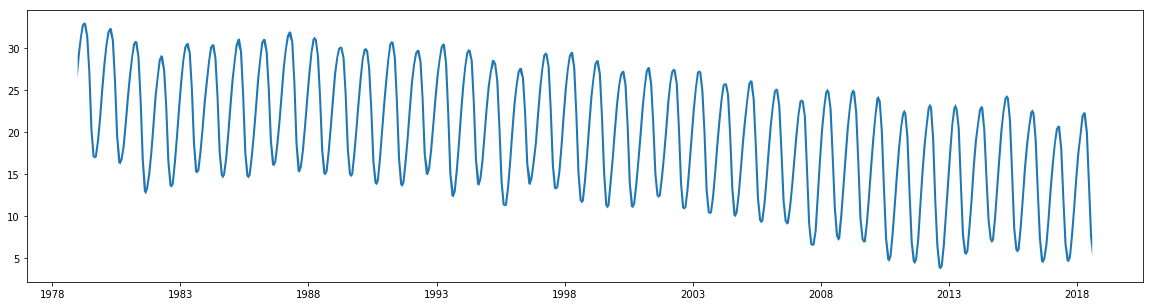

In [10]:
monthly_min = series.resample('MS').min()
monthly_max = series.resample('MS').max()
yearly_min = series.resample('YS').min()
yearly_mean = series.resample('YS').mean()
yearly_max = series.resample('YS').max()
yearly_min.index, yearly_mean.index, yearly_max.index = [yearly_min.index.year] * 3

df_min_month = pivot_months(monthly_min)
df_max_month = pivot_months(monthly_max)

# %%
plt.figure(figsize=[20, 5])
plt.fill_between(monthly_min.index, monthly_min.values, monthly_max.values);

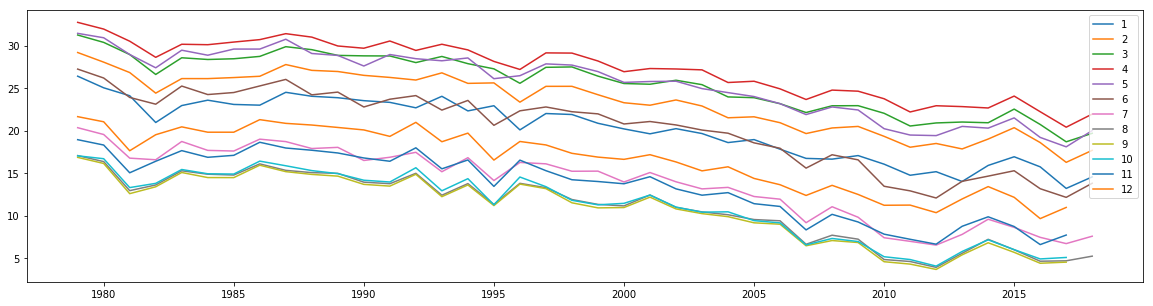

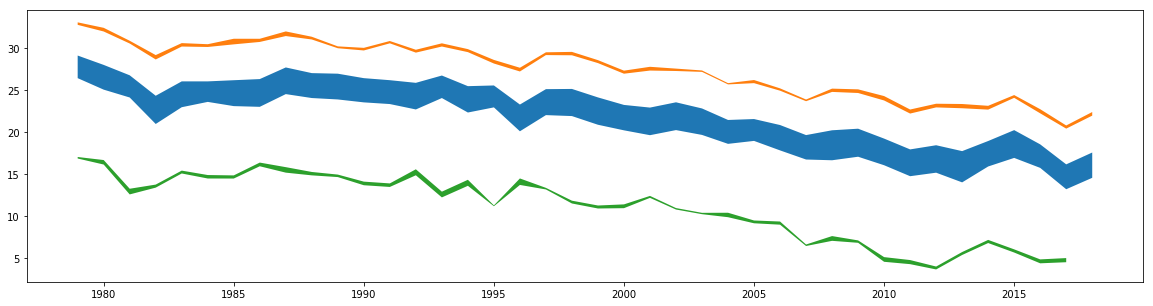

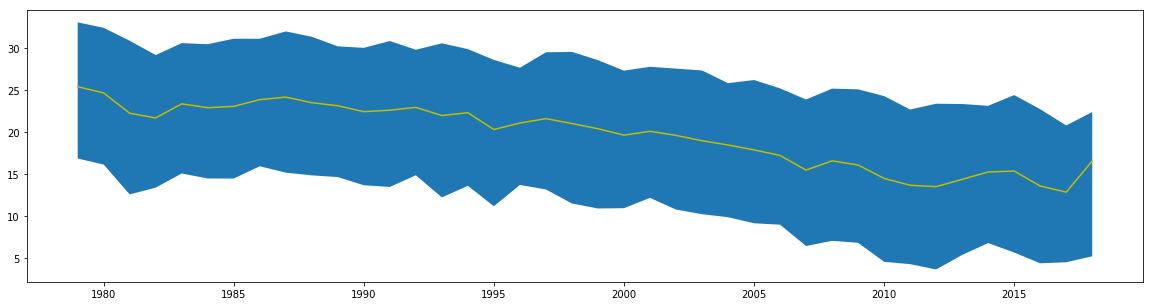

In [11]:
# %%
plt.figure(figsize=[20, 5])
plt.plot(df_min_month)
labels = list(range(1, 13))
plt.legend(labels)
plt.show()

# %%
jan = 1
apr = 4
sep = 9
plt.figure(figsize=[20, 5])
plt.fill_between(df_min_month.index, df_min_month[jan], df_max_month[jan])
plt.fill_between(df_min_month.index, df_min_month[apr], df_max_month[apr])
plt.fill_between(df_min_month.index, df_min_month[sep], df_max_month[sep])
plt.show()

# %%
plt.figure(figsize=[20, 5])
plt.fill_between(yearly_min.index, yearly_min, yearly_max)
plt.plot(yearly_mean, 'y')
plt.show()

# %% SAVE FORECAST
today = pd.datetime.today()
series_min.tail(365).to_csv(output_path / f'min_{today.year}-{today.month}.csv')
series_centr.tail(365).to_csv(output_path / f'central_{today.year}-{today.month}.csv')
series_max.tail(365).to_csv(output_path / f'max_{today.year}-{today.month}.csv')